In [12]:
import pickle

import pandas as pd
import matplotlib.pyplot as plt

# Read Pickle File and Ball Positions

In [13]:
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)

In [14]:
ball_positions = [x.get(1, []) for x in ball_positions]

ball_positions_df = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2'])

ball_positions_df = ball_positions_df.interpolate()
ball_positions_df = ball_positions_df.bfill()

ball_positions_df

,x1,y1,x2,y2
0,1097.276733,656.473755,1117.319580,676.158081
1,1097.276733,656.473755,1117.319580,676.158081
2,1097.276733,656.473755,1117.319580,676.158081
3,1097.276733,656.473755,1117.319580,676.158081
4,1097.276733,656.473755,1117.319580,676.158081
...,...,...,...,...
283,1511.068115,748.461914,1531.878784,770.573547
284,1531.764771,763.712219,1553.319946,787.094421
285,1554.047974,781.814392,1574.172729,803.412415
286,1575.308838,801.131470,1598.284546,825.675659


# Calculate Frames where Ball is Hit

In [15]:
ball_positions_df['mid_y'] = (ball_positions_df['y1'] + ball_positions_df['y2']) / 2
ball_positions_df['mid_y_rolling_mean'] = ball_positions_df['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

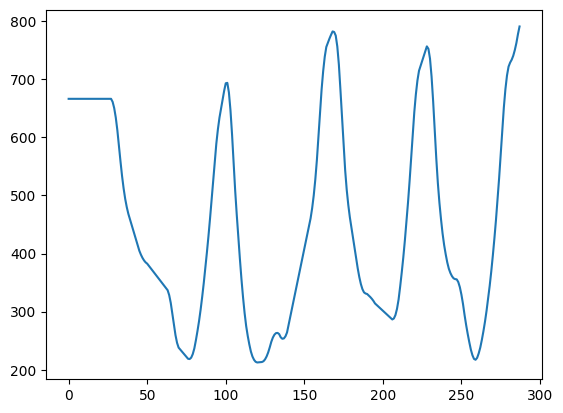

In [16]:
plt.plot(ball_positions_df['mid_y_rolling_mean'])

In [17]:
ball_positions_df['delta_y'] = ball_positions_df['mid_y_rolling_mean'].diff()

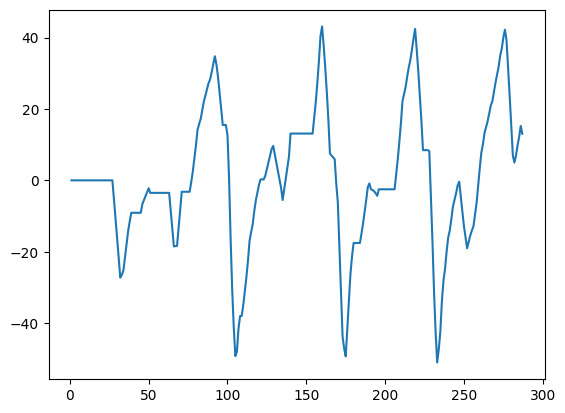

In [18]:
plt.plot(ball_positions_df['delta_y'])

In [19]:
ball_positions_df['ball_hit'] = 0

In [23]:
ball_positions_df['ball_hit'] = 0
minimum_change_frames_for_hit = 10

for i in range(1, len(ball_positions_df) - int(minimum_change_frames_for_hit * 1.2)):
    negative_position_change = ball_positions_df['delta_y'].iloc[i] > 0 and ball_positions_df['delta_y'].iloc[i+1] < 0
    positive_position_change = ball_positions_df['delta_y'].iloc[i] < 0 and ball_positions_df['delta_y'].iloc[i+1] > 0

    if negative_position_change or positive_position_change:
        change_count = 0
        for change_frame in range(i+1, i + int(minimum_change_frames_for_hit * 1.2) + 1):
            negative_position_change_following_frame = ball_positions_df['delta_y'].iloc[i] > 0 and ball_positions_df['delta_y'].iloc[change_frame] < 0
            positive_position_change_following_frame = ball_positions_df['delta_y'].iloc[i] < 0 and ball_positions_df['delta_y'].iloc[change_frame] > 0

            if negative_position_change and negative_position_change_following_frame:
                change_count += 1
            elif positive_position_change and positive_position_change_following_frame:
                change_count += 1

        # Only mark the ball hit if there are enough consecutive frames with direction change
        if change_count > minimum_change_frames_for_hit - 1:
            ball_positions_df['ball_hit'].iloc[i] = 1


C:\Users\jkmen\AppData\Local\Temp\ipykernel_26672\410326512.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ball_positions_df['ball_hit'].iloc[i] = 1
C:\Users\jkmen\AppData\Local\Temp\ipykernel_26672\410326512.py:21: SettingWithCopyWarn

In [24]:
ball_positions_df[ball_positions_df['ball_hit'] == 1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
77,716.047913,213.645447,733.502625,231.572571,222.609009,218.273810,-0.516102,1
101,1269.054932,656.896606,1291.486450,680.187073,668.541840,693.810071,0.732159,1
120,1106.939209,206.284012,1119.958636,219.600671,212.942341,212.414004,-1.223260,1
136,1035.994700,244.730016,1048.903288,257.201440,250.965728,253.253750,-2.470722,1
168,848.555969,785.668396,864.452820,802.697754,794.183075,782.326025,5.918080,1
206,894.058044,272.952789,908.039612,289.932526,281.442657,286.460205,-2.508774,1
228,1271.243530,762.582642,1289.628784,782.338257,772.460449,756.604427,8.192691,1
259,1024.929108,218.674690,1038.959839,232.890083,225.782387,217.086172,-1.536767,1


In [25]:
ball_hit_frames = ball_positions_df[ball_positions_df['ball_hit'] == 1].index.tolist()

ball_hit_frames

[77, 101, 120, 136, 168, 206, 228, 259]